<a href="https://colab.research.google.com/github/1989HIM/Used-Car-Price-Prediction/blob/main/USED_CARS_PRICE_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive;
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import missingno
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,AdaBoostRegressor,BaggingRegressor,ExtraTreesRegressor,GradientBoostingRegressor,StackingRegressor,VotingRegressor
from sklearn.metrics import f1_score,mean_squared_error,r2_score,mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression,Ridge,Lasso,SGDRegressor
import xgboost as xgb
from sklearn.svm import SVR

In [ ]:
data=pd.read_csv('drive/MyDrive/CAR_PRICE_PREDICTION/data.csv')
data.head(2)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,torque,rpm
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,5.0,190.0,1000.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0,250.0,2000.0


In [ ]:
data.shape

(8128, 14)

#### <b>MISSING VALUES ANALYSIS</b>



In [ ]:
data.replace(0,np.nan,inplace=True)
miss_per=round(data.isna().sum()*100/len(data),2)
print(f"{'Feature':{15}}{'Missing %'}\n{'='*25}")
print(miss_per)

Feature        Missing %
name             0.00
year             0.00
selling_price    0.00
km_driven        0.00
fuel             0.00
seller_type      0.00
transmission     0.00
owner            0.00
mileage          2.93
engine           2.72
max_power        2.72
seats            2.72
torque           2.73
rpm              5.41
dtype: float64


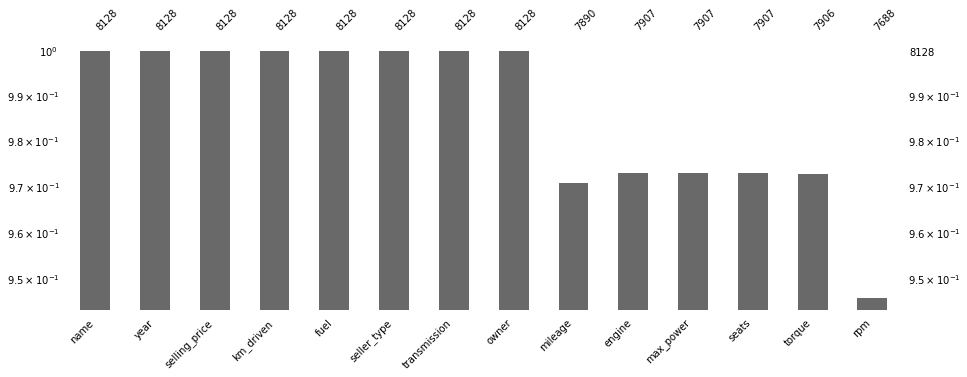

In [ ]:
missingno.bar(data,log=True,figsize=(15,5),fontsize=10)
plt.show()

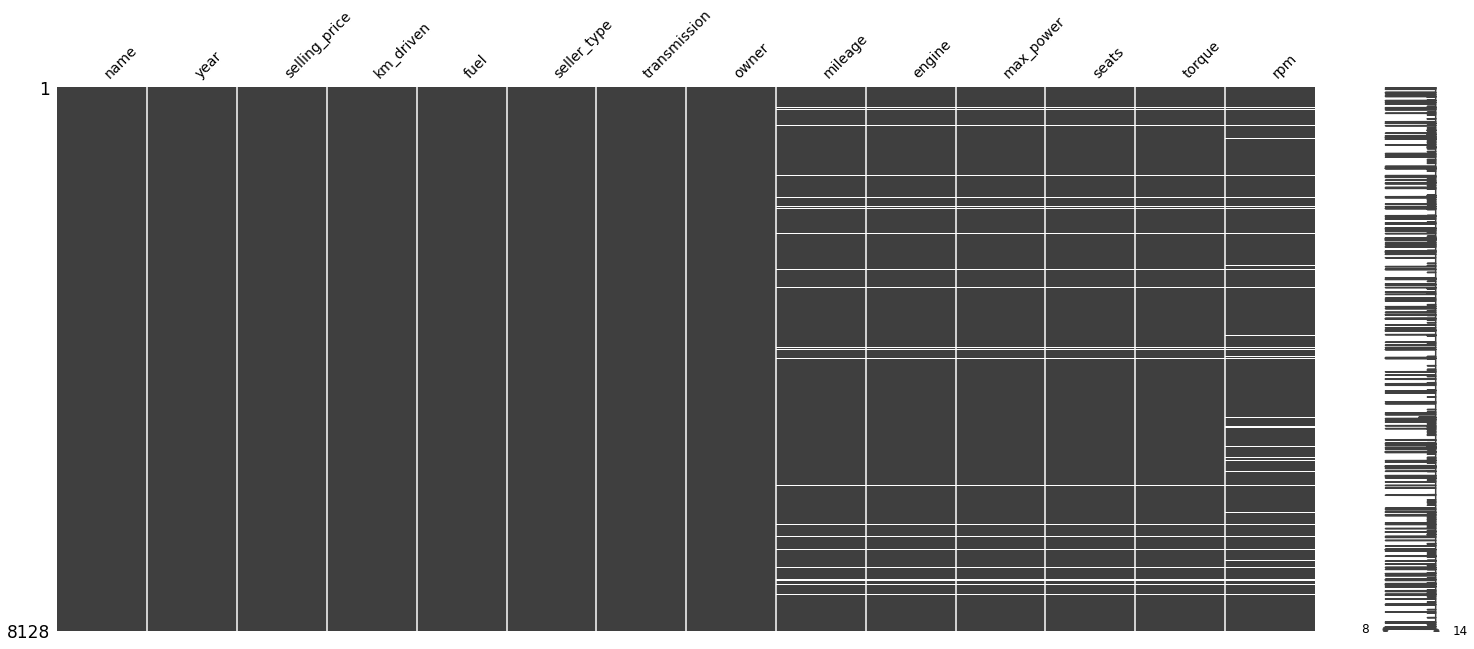

In [ ]:
missingno.matrix(data,fontsize=14)
plt.show()

#### <b>Summary:-</b><br>
- From the missing values pattern, it appears that the level of missingness is construct level which is generally referred when a case/example is partially filled. 
- Although, the column wise missing value percentage ranges from 2-5 % but row wise percentage is about 42 %, which is very high.
- **Rpm** contains 5.41% of missing values and removing these missing values row wise will result in significant loss of data. The original dataset (i.e before cleaning) has a **torque** feature in which the values are like 190Nm @ 500 rpm.That feature was splitted into two features i.e. torque and rpm.

#### <b>Handling Missing Values</b>
- **Rpm** feature can be dropped as it doesn't show any correlation with selling price.
- For other features with missing values, we need to focus on the following question:-
  - Is missingness low enough to delete ?
  - Is ignoring missing data worth it ?
  - Is the impact of missing values features,if included, significant in final prediction?


In [ ]:
data1=data.dropna()
round((data.shape[0]-data1.shape[0])*100/data.shape[0],2)

5.62

- Removing all the missing value cases, shrinks the dataset by **5.62 %**

In [ ]:
# Splitting the dataset on the basis of valid and missing value cases
data_temp=data.fillna(-1)
data_valid=data_temp[data_temp['mileage']!=-1]
data_miss=data_temp[data_temp['mileage']==-1]
print(data_valid.shape)
print(data_miss.shape)

(7890, 14)
(238, 14)


**Analyzing the difference in the distribution of selling price corresponding to valid and missing data**
- Is the difference significant ?
- Will removal of all the cases with missing data leads to biased results ?

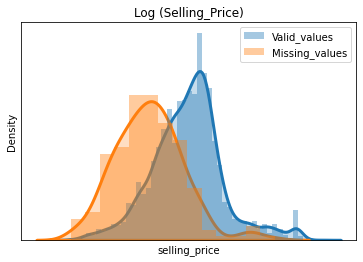

In [ ]:
sns.distplot(np.log(data_valid['selling_price']),kde_kws = {'shade': True, 'linewidth': 3},label='Valid_values')
sns.distplot(np.log(data_miss['selling_price']),kde_kws = {'shade': True, 'linewidth': 3},label='Missing_values')
plt.yticks([])
plt.xticks([])
plt.title('Log (Selling_Price)')
plt.legend()
plt.show()

- By visualizing the log of selling price corrosponding to valid and missing values, it appears that there is a difference in the distribution.
- We need to determine whether this difference is significant or not by a statistical method.
- If the difference is significant i.e. p-value < alpha, then missingness can be classified as **Missing At Random (MAR)** otherwise **Missing Completely At Random (MCAR)**.

##### **Statistical Analysis for distribution:-**</br>
- We can perform t-test to check the difference in the distribution **BUT** t-test requires an assumption that data needs to be normally distributed.
- To check the normality assumption we can perform **Shapiro-Wilk** test in which :</br> Ho : Data is normally distributed</br> Ha : Data isn't normally distributed

In [ ]:
print(stats.shapiro(data_valid['selling_price']))
print(stats.shapiro(data_miss['selling_price']))
print('\n')
print(stats.shapiro(np.log(data_valid['selling_price'])))
print(stats.shapiro(np.log(data_miss['selling_price'])))

(0.5374230742454529, 0.0)
(0.49056923389434814, 1.18300453293676e-25)


(0.9778522253036499, 2.855246023446581e-33)
(0.9783357381820679, 0.0010500450152903795)


- The p-values in both Log and without Log of data is close to zero.Thus rejecting the null hypothesis.Therefore can't perform t-test.
- Let's try **kolmogorov-smirnov test** which checks the null hypothesis that two samples come from the same distribution

In [ ]:
# kolmogorov-smirnov test 
stats.ks_2samp(data_valid['selling_price'],data_miss['selling_price'])

Ks_2sampResult(statistic=0.4674324482644769, pvalue=2.856318891836063e-44)

- **The pvalue is almost negligible, giving us strong evidence for rejecting the null hypothesis i.e. distributions are not from same sample** <br>

##### **SKEWNESS & KURTOSIS COMPARISION OF FEATURES**


In [ ]:
print('SKEWNESS','Valid'.rjust(13),'Missing'.rjust(13),\
      'KURTOSIS'.rjust(15),'Valid'.rjust(13),'Missing'.rjust(13),'\n','='*80)
columns=['selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'seats',
       'torque']
for i in columns:
    print(f'{i:{15}}{round(data_valid[i].skew(),2):{7}}{round(data_miss[i].skew(),2):{12}}\
          {i:{15}}{round(data_valid[i].kurtosis(),2):{7}}{round(data_miss[i].kurtosis(),2):{12}}')

SKEWNESS         Valid       Missing        KURTOSIS         Valid       Missing 
selling_price     4.16        5.24          selling_price    20.69       34.75
km_driven        11.35        0.85          km_driven       388.55        1.85
mileage           0.07           0          mileage          -0.33           0
engine            1.13        4.48          engine            0.73        21.0
max_power         1.64        4.68          max_power         3.81       24.04
seats             1.98        3.48          seats             3.78       10.32
torque            75.3        5.87          torque         6177.22       37.32


##### **Summary:**
- Since the data is skewed, we can't perform t-test as normality assumption is violated.
- From kolmogorov-smirnov test, we infer that removing all the cases with missing values can create some biasedness in prediction.
- Removing all the missing value cases,even though percentage looks small, might not be beneficial.
- Therefore, we need imputation strategies for missing values in mileage,engine,max_power,seats and torque.

In [ ]:
# Creating a new feature years_old and Dropping name and rpm.
import datetime
current_date=datetime.datetime.now()
data['years_old']=data['year'].apply(lambda x:current_date.year-x)
data1=data.drop(['name','year','rpm'],axis=1)

In [ ]:
data1.head()

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,torque,years_old
0,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,5.0,190.0,7
1,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0,250.0,7
2,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78.00,5.0,12.7,15
3,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,5.0,22.4,11
4,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,5.0,11.5,14


In [ ]:
data1.seller_type.unique()

array(['Individual', 'Dealer', 'Trustmark Dealer'], dtype=object)

#### **HEATMAP**

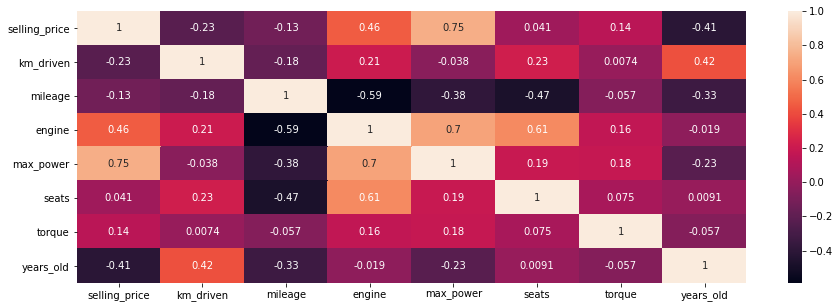

In [ ]:
plt.figure(figsize=(15,5))
sns.heatmap(data1.corr(),annot=True,fmt='.2g')
plt.show()

#### **MISSING VALUES IMPUTATION STRATEGY:**</br>
- Missing values are present in **mileage,engine,max_power,seats,torque and rpm.**
- First, we will split dataset into two parts i.e one with complete cases and another with incomplete cases.
- Then Complete cases will be used for training purpose to impute the values into incomplete cases.
- The **max_power** has strong positive correlation of 0.75 with selling price, 0.7 with engine and negative correlation with mileage and years_old.


In [ ]:
data_temp=data1.fillna(-1)
data_valid=data_temp[data_temp['mileage']!=-1]
data_miss=data_temp[data_temp['mileage']==-1]
print(data_valid.shape)
print(data_miss.shape)

(7890, 12)
(238, 12)


##### **1) Max_power**</br>
Max power has strong positive correlation of 0.75 with **selling price** and negative correlation with **years_old**. (#these are complete features)

In [ ]:
X=data_valid[['selling_price','years_old']]
y=data_valid['max_power']
rf=RandomForestRegressor(n_estimators=50)
rf.fit(X,y)
y_pred=rf.predict(X)
print('R2_score =',round(rf.score(X,y),2))
print('RMSE =',round(np.sqrt(mean_squared_error(y_pred,y)),2))
#imputing max_power missing values
max_pow_miss=rf.predict(data_miss[['selling_price','years_old']])
data_miss['max_power']=max_pow_miss

R2_score = 0.86
RMSE = 13.49


##### **2) Engine**</br>


In [ ]:
X=data_valid[['selling_price','max_power','km_driven']]
y=data_valid['engine']
rf=RandomForestClassifier(n_estimators=50)
rf.fit(X,y)
y_pred=rf.predict(X)
print('R2_score =',round(rf.score(X,y),2))
print('RMSE =',round(np.sqrt(mean_squared_error(y_pred,y)),2))
data_miss['engine']=rf.predict(data_miss[['selling_price','max_power','km_driven']])

R2_score = 1.0
RMSE = 15.02


#### **3) Mileage**

In [ ]:
X=data_valid[['selling_price','engine','max_power','years_old']] #not including mileage since it is missing
y=data_valid['mileage'].astype('int')
rf=RandomForestRegressor(n_estimators=50)
rf.fit(X,y)
y_pred=rf.predict(X)
print('R2_score =',round(rf.score(X,y),2))
print('RMSE =',round(np.sqrt(mean_squared_error(y_pred,y)),2)) 
data_miss['mileage']=rf.predict(data_miss[['selling_price','engine','max_power','years_old']])

R2_score = 0.98
RMSE = 0.52


##### **4) Seats**


In [ ]:
X=data_valid[['engine','mileage','km_driven']] #not including mileage since it is missing
y=data_valid['seats']
rf=RandomForestClassifier(n_estimators=50)
rf.fit(X,y)
y_pred=rf.predict(X)
print('R2_score =',round(rf.score(X,y),2))
print('RMSE =',round(np.sqrt(mean_squared_error(y_pred,y)),2)) 
data_miss['seats']=rf.predict(data_miss[['engine','mileage','km_driven']]).astype('int')

R2_score = 0.99
RMSE = 0.17


##### **5) Torque**


In [ ]:
X=data_valid[['engine','max_power']] #not including mileage since it is missing
y=data_valid['torque']
rf=RandomForestRegressor(n_estimators=50)
rf.fit(X,y)
y_pred=rf.predict(X)
print('R2_score =',round(rf.score(X,y),2))
print('RMSE =',round(np.sqrt(mean_squared_error(y_pred,y)),2)) 
data_miss['torque']=rf.predict(data_miss[['engine','max_power']])

R2_score = 0.77
RMSE = 219.85


**Concatinated dataset and shuffled. All missing values imputed.**

In [ ]:
# Concatinating dataset after imputing values
data2=pd.concat([data_valid,data_miss],ignore_index=True)
data2=data2.sample(frac=1).reset_index(drop=True)
data2.head()

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,torque,years_old
0,385000,120000,Petrol,Individual,Manual,First Owner,19.10,1197.0,85.8,5.0,114.0,8
1,150000,80000,Petrol,Individual,Manual,Third Owner,19.70,796.0,46.3,5.0,62.0,14
2,484999,75000,Diesel,Dealer,Manual,First Owner,19.87,1461.0,83.8,5.0,200.0,6
3,400000,70000,Petrol,Individual,Manual,Second Owner,19.10,1197.0,85.8,5.0,114.0,7
4,70000,20000,Diesel,Individual,Manual,First Owner,15.90,1527.0,57.0,5.0,96.0,18


In [ ]:
# Dropping duplicate entries
#data2.drop_duplicates(inplace=True)
#print(data2.shape)

### **Outliers Analysis**</br>

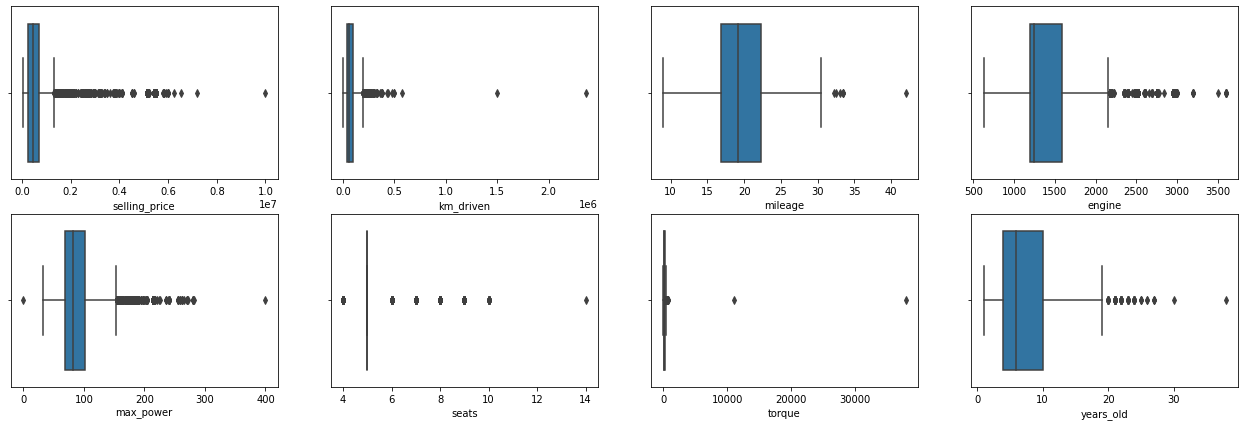

In [ ]:
fig, ax = plt.subplots(2, 4)
sns.boxplot(data2['selling_price'],ax = ax[0,0])
sns.boxplot(data2['km_driven'],ax = ax[0,1])
sns.boxplot(data2['mileage'],ax = ax[0,2])
sns.boxplot(data2['engine'],ax = ax[0,3])
sns.boxplot(data2['max_power'],ax = ax[1,0])
sns.boxplot(data2['seats'],ax = ax[1,1])
sns.boxplot(data2['torque'],ax = ax[1,2])
sns.boxplot(data2['years_old'],ax = ax[1,3])
fig.set_figheight(7)
fig.set_figwidth(22)
plt.show()

In [ ]:
data[data['selling_price']==data.selling_price.max()]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,torque,rpm,years_old
170,Volvo XC90 T8 Excellence BSIV,2017,10000000,30000,Petrol,Individual,Automatic,First Owner,42.0,1969.0,400.0,4.0,640.0,870.0,4


The actual price of brand new <b>"Volvo XC90 T8 Excellence BSIV"</b> is about 1.31 crore, so this selling price looks valid. Although, from the box plot it appears as an outlier but removing a valid outlier doesn't feels like a good idea.

In [ ]:
q1,q3=np.percentile(data2['km_driven'].values,[25,75])
upper_fence=q3+1.5*(q3-q1)
lower_fence=q1-1.5*(q3-q1)
x=data2[data2['km_driven']>upper_fence]
print('Pearson correlation=',stats.pearsonr(x['km_driven'],x['selling_price'])[0])
data2['km_driven'][data2['km_driven']>upper_fence]=upper_fence

Pearson correlation= 0.08071010575941727


Since pearson correlation is negligible, the outliers are assigned with upper_fence value.

In [ ]:
q1,q3=np.percentile(data2['mileage'].values,[25,75])
upper_fence=q3+1.5*(q3-q1)
lower_fence=q1-1.5*(q3-q1)
x=data2[data2['mileage']>upper_fence]
x.sort_values(by='mileage',ascending=False)

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,torque,years_old
3748,10000000,30000,Petrol,Individual,Automatic,First Owner,42.00,1969.0,400.00,4.0,640.0,4
5192,330000,10000,CNG,Individual,Manual,Second Owner,33.44,796.0,40.30,4.0,60.0,2
5568,330000,10000,CNG,Individual,Manual,Second Owner,33.44,796.0,40.30,4.0,60.0,2
6338,260000,67000,CNG,Individual,Manual,First Owner,33.44,796.0,40.30,4.0,60.0,4
1569,370000,16000,CNG,Individual,Manual,First Owner,33.00,796.0,47.30,5.0,69.0,1
1128,270000,80000,CNG,Individual,Manual,Second Owner,32.52,998.0,58.33,5.0,78.0,8
8063,430000,20000,CNG,Individual,Manual,First Owner,32.26,998.0,58.30,4.0,78.0,2


One thing is common here, that all the vehicles,having high mileage, run on CNG fuel. The highest value i.e 42.0 kmpl is correct and verified by internet search. All these values will be kept as it is.

In [ ]:
q1,q3=np.percentile(data2['engine'].values,[25,75])
upper_fence=q3+1.5*(q3-q1)
lower_fence=q1-1.5*(q3-q1)
x=data2[data2['engine']>upper_fence]
data2.sort_values(by='engine',ascending=False).head()

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,torque,years_old
181,4100000,17000,Petrol,Individual,Automatic,First Owner,9.5,3604.0,280.0,5.0,347.0,4
4026,4100000,17000,Petrol,Individual,Automatic,First Owner,9.5,3604.0,280.0,5.0,347.0,4
6215,4100000,17000,Petrol,Individual,Automatic,First Owner,9.5,3604.0,280.0,5.0,347.0,4
4492,4100000,17000,Petrol,Individual,Automatic,First Owner,9.5,3604.0,280.0,5.0,347.0,4
7531,4100000,17000,Petrol,Individual,Automatic,First Owner,9.5,3604.0,280.0,5.0,347.0,4


Outlier values in **engine, max_power and seats** are valid values. These values will not be removed

In [ ]:
data.sort_values(by='torque',ascending=False).head(2)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,torque,rpm,years_old
778,Ford Endeavour Hurricane Limited Edition,2013,1075000,110000,Diesel,Individual,Automatic,Third Owner,12.8,2953.0,156.0,7.0,38038.7,1250.0,8
2000,Honda Jazz Select Edition Active,2011,350000,80000,Petrol,Individual,Manual,Second Owner,16.0,1198.0,90.0,5.0,11011.2,2400.0,10


The actual torque of **Ford Endeavour** is **380Nm @ 2500rpm** and **Honda Jazz 110 (11.2) @ 4800**. So, imputing the correct values.

In [ ]:
data2['torque'][data2['torque']==38038.7]=380
data2['torque'][data2['torque']==11011.2]=110
data2['torque'][data2['torque']==-1]=58.560
data2['max_power'][data2['max_power']==-1]=38.840

In [ ]:
data2.sort_values(by='years_old',ascending=False).head(2)

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,torque,years_old
2239,300000,10000,Diesel,Individual,Manual,Third Owner,15.00,998.0,96.588,5.0,149.50,38
4133,55000,120000,LPG,Individual,Manual,Second Owner,15.96,796.0,41.140,4.0,60.12,30


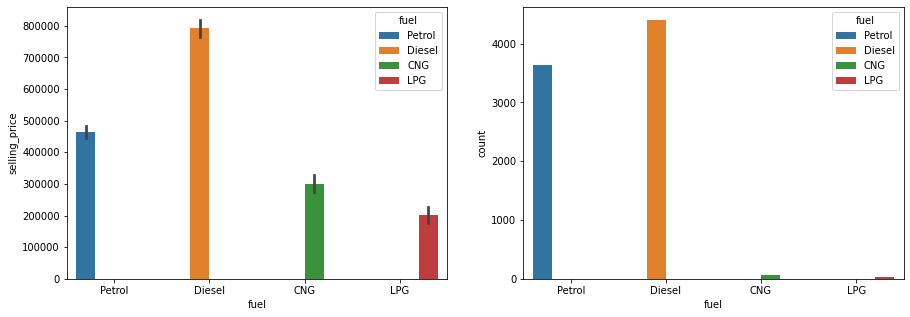

In [ ]:
fig,ax=plt.subplots(1,2)
sns.barplot(x='fuel',y='selling_price',hue='fuel',data=data2,ax=ax[0])
sns.countplot(x='fuel',hue='fuel',data=data2,ax=ax[1])
fig.set_figwidth(15)
fig.set_figheight(5)
plt.show()

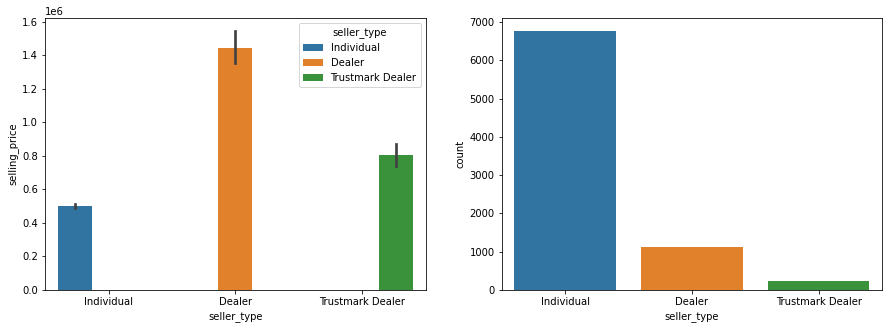

In [ ]:
fig,ax=plt.subplots(1,2)
sns.barplot(x='seller_type',y='selling_price',hue='seller_type',data=data2,ax=ax[0])
sns.countplot(x='seller_type',data=data2,ax=ax[1],dodge=True)
fig.set_figwidth(15)
fig.set_figheight(5)
fig.set
plt.show()

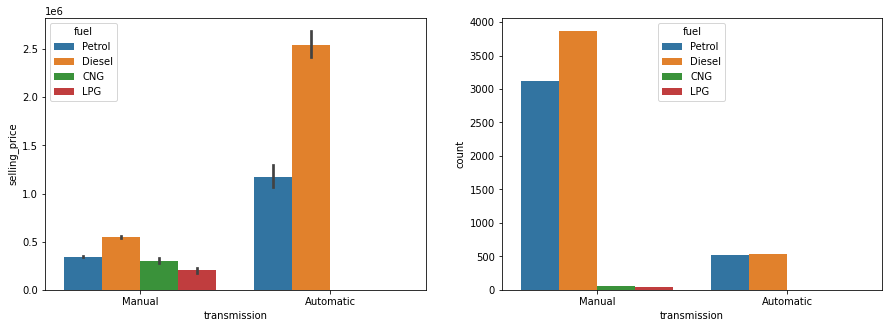

In [ ]:
fig,ax=plt.subplots(1,2)
sns.barplot(x='transmission',y='selling_price',hue='fuel',data=data2,ax=ax[0])
sns.countplot(x='transmission',hue='fuel',data=data2,ax=ax[1])
fig.set_figwidth(15)
fig.set_figheight(5)
plt.show()

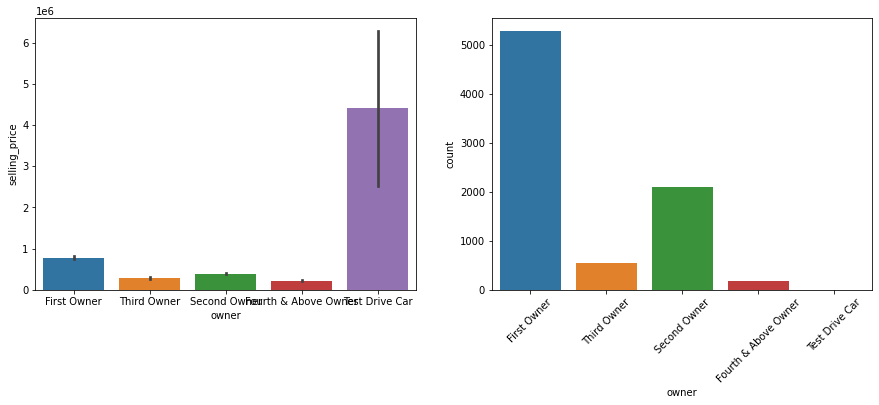

In [ ]:
fig,ax=plt.subplots(1,2)
plt.xticks(rotation=45)
sns.barplot(x='owner',y='selling_price',data=data2,ax=ax[0])
sns.countplot(x='owner',data=data2,ax=ax[1])
plt.xticks(rotation=45)
fig.set_figwidth(15)
fig.set_figheight(5)
plt.show()

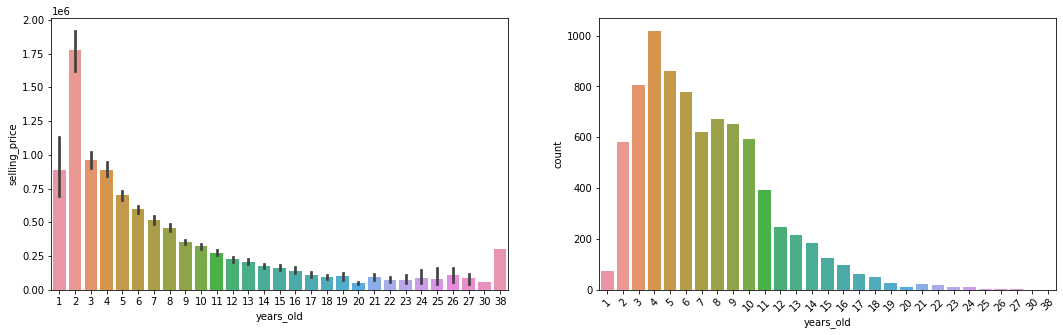

In [ ]:
fig,ax=plt.subplots(1,2)
plt.xticks(rotation=45)
sns.barplot(x='years_old',y='selling_price',data=data2,ax=ax[0])
sns.countplot(x='years_old',data=data2,ax=ax[1])
plt.xticks(rotation=45)
fig.set_figwidth(18)
fig.set_figheight(5)
plt.show()

#### **Maping of Categorical Variables**

In [ ]:
mydict1={'Manual':1,'Automatic':2}
mydict2={'Diesel':4,'Petrol':3,'LPG':2,'CNG':1}
mydict3={'First Owner':4, 'Second Owner':3, 'Third Owner':2,'Fourth & Above Owner':1, 'Test Drive Car':5}
mydict4={'Individual':1, 'Dealer':3, 'Trustmark Dealer':2}

In [ ]:
data2['transmission']=data2['transmission'].map(mydict1)
data2['fuel']=data2['fuel'].map(mydict2)
data2['owner']=data2['owner'].map(mydict3)
data2['seller_type']=data2['seller_type'].map(mydict4)

In [ ]:
data2.head()

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,torque,years_old
0,385000,120000,3,1,1,4,19.10,1197.0,85.8,5.0,114.0,8
1,150000,80000,3,1,1,2,19.70,796.0,46.3,5.0,62.0,14
2,484999,75000,4,3,1,4,19.87,1461.0,83.8,5.0,200.0,6
3,400000,70000,3,1,1,3,19.10,1197.0,85.8,5.0,114.0,7
4,70000,20000,4,1,1,4,15.90,1527.0,57.0,5.0,96.0,18


#### **Multicollinearity Check**

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["data2"] = data2.columns
vif_data["VIF_1"] = [variance_inflation_factor(data2.values, i) for i in range(len(data2.columns))]
vif_data.sort_values('VIF_1',ascending=False,ignore_index=True)

,data2,VIF_1
0,fuel,95.104680
1,seats,51.823991
2,engine,47.339003
3,mileage,39.911873
4,max_power,37.134368
5,owner,30.467614
6,transmission,19.277710
7,torque,14.114908
8,years_old,6.858649
9,km_driven,6.167965


Multicollinearity level in most of the features are very high. Let's scale these features and try VIF once more.

In [ ]:
# Scaling all the features except Selling_price
scaled=StandardScaler().fit_transform(data2[['km_driven','mileage','engine','max_power','seats','torque','years_old','fuel','seller_type','transmission','owner']])

In [ ]:
data2_scaled=data2.copy()
data2_scaled[['km_driven','mileage','engine','max_power','seats','torque','years_old','fuel','seller_type','transmission','owner']]=scaled

In [ ]:
data2_scaled.head()

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,torque,years_old
0,385000,1.186431,-0.953217,-0.437525,-0.385158,0.640081,-0.074804,-0.514652,-0.152674,-0.43237,-0.546375,0.198816
1,150000,0.268294,-0.953217,-0.437525,-0.385158,-2.148011,0.078209,-1.314519,-1.262564,-0.43237,-1.083659,1.682495
2,484999,0.153527,0.869782,2.421162,-0.385158,0.640081,0.121563,0.011943,-0.208871,-0.43237,0.342209,-0.295744
3,400000,0.038760,-0.953217,-0.437525,-0.385158,-0.753965,-0.074804,-0.514652,-0.152674,-0.43237,-0.546375,-0.048464
4,70000,-1.108912,0.869782,-0.437525,-0.385158,0.640081,-0.890877,0.143592,-0.961910,-0.43237,-0.732358,2.671615


In [ ]:
vif_data["data2_scaled"] = data2_scaled.columns
vif_data["VIF_2"] = [variance_inflation_factor(data2_scaled.values, i) for i in range(len(data2_scaled.columns))]
vif_data.sort_values('VIF_2',ascending=False,ignore_index=True)

,data2,VIF_1,data2_scaled,VIF_2
0,max_power,37.134368,max_power,5.163375
1,engine,47.339003,engine,5.023781
2,torque,14.114908,torque,3.941524
3,mileage,39.911873,mileage,2.674529
4,fuel,95.104680,fuel,2.357786
5,seats,51.823991,seats,2.299420
6,years_old,6.858649,years_old,2.294974
7,km_driven,6.167965,km_driven,1.778124
8,selling_price,4.988098,selling_price,1.720891
9,transmission,19.277710,transmission,1.692594


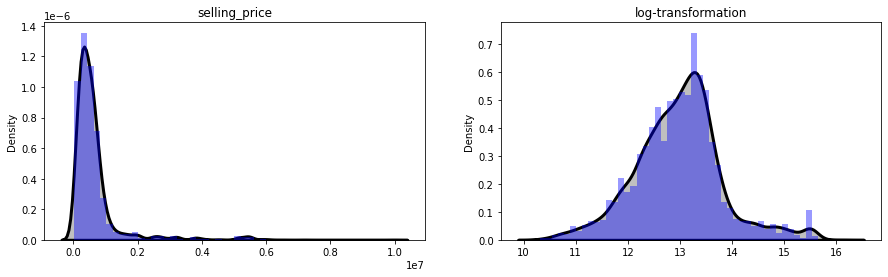

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(15,4))
axes[0].set_title('selling_price')
sns.distplot(data2['selling_price'].values.reshape(-1,1),ax=axes[0],kde_kws = {'shade': True, 'linewidth': 3,'color':'black','fill':True},color='blue')
axes[1].set_title('log-transformation')
sns.distplot(np.log(data2['selling_price'].values.reshape(-1,1)),ax=axes[1],kde_kws = {'shade': True, 'linewidth': 3,'color':'black','fill':True},color='blue')
plt.show()

In [ ]:
data2_scaled['selling_price']=np.log(data2_scaled['selling_price'])

In [ ]:
data2_scaled.head()

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,torque,years_old
0,12.860999,1.186431,-0.953217,-0.437525,-0.385158,0.640081,-0.074804,-0.514652,-0.152674,-0.43237,-0.546375,0.198816
1,11.918391,0.268294,-0.953217,-0.437525,-0.385158,-2.148011,0.078209,-1.314519,-1.262564,-0.43237,-1.083659,1.682495
2,13.091902,0.153527,0.869782,2.421162,-0.385158,0.640081,0.121563,0.011943,-0.208871,-0.43237,0.342209,-0.295744
3,12.899220,0.038760,-0.953217,-0.437525,-0.385158,-0.753965,-0.074804,-0.514652,-0.152674,-0.43237,-0.546375,-0.048464
4,11.156251,-1.108912,0.869782,-0.437525,-0.385158,0.640081,-0.890877,0.143592,-0.961910,-0.43237,-0.732358,2.671615


In [ ]:
X=data2_scaled.drop('selling_price',axis=1)
y=data2_scaled['selling_price']

In [ ]:
# OLS
import statsmodels.api as sm
X= sm.add_constant(X)
result = sm.OLS(y,X).fit()
# printing the summary table
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     5030.
Date:                Tue, 20 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:51:45   Log-Likelihood:                -1749.9
No. Observations:                8128   AIC:                             3524.
Df Residuals:                    8116   BIC:                             3608.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           12.9734      0.003   3894.601   

#### **Modelling**

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,shuffle=True,random_state=12)

In [ ]:
# LINEAR REGRESSION
def linear_regression(X_train,y_train,X_test,y_test):
  y_pred=LinearRegression().fit(X,y).predict(X_test)
  return (mean_squared_error(y_test,y_pred))

#RIDGE
def ridge_regression(X_train,y_train,X_test,y_test):
  y_pred=Ridge(alpha=0.5).fit(X_train,y_train).predict(X_test)
  return (mean_squared_error(y_test,y_pred))

#LASSO
def lasso_regression(X_train,y_train,X_test,y_test):
  y_pred=Lasso(alpha=0.5).fit(X_train,y_train).predict(X_test)
  return (mean_squared_error(y_test,y_pred))

#KNN
def knn_regression(X_train,y_train,X_test,y_test):
  y_pred=KNeighborsRegressor(n_neighbors=2).fit(X_train,y_train).predict(X_test)
  return (mean_squared_error(y_test,y_pred))

#RANDOM FOREST
def randomforest_reg(X_train,y_train,X_test,y_test):
  y_pred=RandomForestRegressor(max_depth=3).fit(X_train,y_train).predict(X_test)
  return (mean_squared_error(y_test,y_pred))
#BAGGING
def bagging_reg(X_train,y_train,X_test,y_test):
  y_pred=BaggingRegressor(base_estimator=SVR(),n_estimators=10, random_state=0).fit(X_train,y_train).predict(X_test)
  return (mean_squared_error(y_test,y_pred))

#ADABOOST
def adaboost_reg(X_train,y_train,X_test,y_test):
  y_pred=AdaBoostRegressor().fit(X_train,y_train).predict(X_test)
  return (mean_squared_error(y_test,y_pred))

#XGBOOST
def xgboost_reg(X_train,y_train,X_test,y_test):
  y_pred=xgb.XGBRFRegressor(objective='reg:linear',n_estimators=10).fit(X_train,y_train).predict(X_test)
  return (mean_absolute_error(y_test,y_pred))

#SGDRegressor
def sgd_reg(X_train,y_train,X_test,y_test):
  y_pred=SGDRegressor().fit(X_train,y_train).predict(X_test)
  return (mean_squared_error(y_test,y_pred))

#EXTRA_TREES
def extra_trees_reg(X_train,y_train,X_test,y_test):
  y_pred=ExtraTreesRegressor().fit(X_train,y_train).predict(X_test)
  return (mean_squared_error(y_test,y_pred))

#GRADIENT BOOSTING
def gradientB_reg(X_train,y_train,X_test,y_test):
  y_pred=GradientBoostingRegressor().fit(X_train,y_train).predict(X_test)
  return (mean_squared_error(y_test,y_pred))

In [ ]:
def model(X,y,test_size):
  #X=dataset.drop('selling_price',axis=1)
  #y=dataset['selling_price']
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_size,shuffle=True,random_state=12)
  #LINEAR REGRESSION
  result=linear_regression(X_train,y_train,X_test,y_test)
  #RIDGE
  result1=ridge_regression(X_train,y_train,X_test,y_test)
  #LASSO
  result2=lasso_regression(X_train,y_train,X_test,y_test)
  #KNN
  result3=knn_regression(X_train,y_train,X_test,y_test)
  #RANDOM FOREST
  result4=randomforest_reg(X_train,y_train,X_test,y_test)
  #BAGGING
  result5=bagging_reg(X_train,y_train,X_test,y_test)
  #ADABOOST
  result6=adaboost_reg(X_train,y_train,X_test,y_test)
  #XGBOOST
  result7=xgboost_reg(X_train,y_train,X_test,y_test)
  #SGDRegressor
  result8=sgd_reg(X_train,y_train,X_test,y_test)
  #EXTRA_TREES
  result9=extra_trees_reg(X_train,y_train,X_test,y_test)
  #GRADIENT BOOSTING
  result10=gradientB_reg(X_train,y_train,X_test,y_test)
  print('LINEAR: ',result,'\n','RIDGE: ',result1,'\n','LASSO:',result2,'\n','KNN: ',result3,'\n',
        'RANDOMFOREST:',result4,'\n','BAGGING:',result5,'\n','ADABOOST:',result6,'\n','XGBOOST:',result7,'\n','SGDReg:',result8,'\n',
        'EXTRA_TREES:',result9,'\n','GRADIENT_BOOSTING',result10)

In [ ]:
model(X,y,0.3)

[15:52:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
LINEAR:  0.09036163183001017 
 RIDGE:  0.0907822389367786 
 LASSO: 0.5300514694802575 
 KNN:  0.07404908749842304 
 RANDOMFOREST: 0.14112004239538312 
 BAGGING: 0.05927558577840416 
 ADABOOST: 0.09765654956957463 
 XGBOOST: 0.31410153701792015 
 SGDReg: 0.09110138798011704 
 EXTRA_TREES: 0.04265919862696081 
 GRADIENT_BOOSTING 0.05304784739645403


ExtraTreesRegressor and Gradient Boosting has least mean square error. Therefore adopting these algorithms for further analysis.

In [ ]:
#performace metric
def metric(y_pred,y_test):
  y_pred1=np.exp(y_pred)
  y_test1=np.exp(y_test)
  print('MSE_log      =',round(mean_squared_error(y_pred,y_test),3))
  print('RMSE_log     =',round(np.sqrt(mean_squared_error(y_pred,y_test)),3))
  print('MAE_log      =',round(mean_absolute_error(y_pred,y_test),3))
  print('r2_score     =',round(r2_score(y_pred,y_test),4))
  print('MSE_exp      =',round(mean_squared_error(y_pred1,y_test1),3))
  print('RMSE_exp     =',round(np.sqrt(mean_squared_error(y_pred1,y_test1)),3))
  print('MAE_exp      =',round(mean_absolute_error(y_pred1,y_test1),3))
  print('r2_score_exp =',round(r2_score(y_pred1,y_test1),3))

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,shuffle=True,random_state=12)
y_pred=ExtraTreesRegressor().fit(X_train,y_train).predict(X_test)
metric(y_pred,y_test)

MSE_log      = 0.043
RMSE_log     = 0.206
MAE_log      = 0.137
r2_score     = 0.9377
MSE_exp      = 13391831948.89
RMSE_exp     = 115723.083
MAE_exp      = 60446.028
r2_score_exp = 0.98


In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,shuffle=True,random_state=12)
y_pred=ExtraTreesRegressor().fit(X_train,y_train).predict(X_test)
metric(y_pred,y_test)

MSE_log      = 0.042
RMSE_log     = 0.206
MAE_log      = 0.136
r2_score     = 0.9381
MSE_exp      = 13533681535.938
RMSE_exp     = 116334.352
MAE_exp      = 60467.272
r2_score_exp = 0.98


In [ ]:
y_pred=GradientBoostingRegressor().fit(X_train,y_train).predict(X_test)
metric(y_pred,y_test)

MSE_log      = 0.053
RMSE_log     = 0.23
MAE_log      = 0.169
r2_score     = 0.9195
MSE_exp      = 36200363376.726
RMSE_exp     = 190263.931
MAE_exp      = 94525.228
r2_score_exp = 0.942


In [ ]:
y_pred=GradientBoostingRegressor().fit(X_train,y_train).predict(X_test)
metric(y_pred,y_test)

MSE_log      = 0.053
RMSE_log     = 0.23
MAE_log      = 0.169
r2_score     = 0.9195
MSE_exp      = 36450504378.488
RMSE_exp     = 190920.152
MAE_exp      = 94577.452
r2_score_exp = 0.942


ExtraTreesRegression is performing better than GradientBoostingRegressor

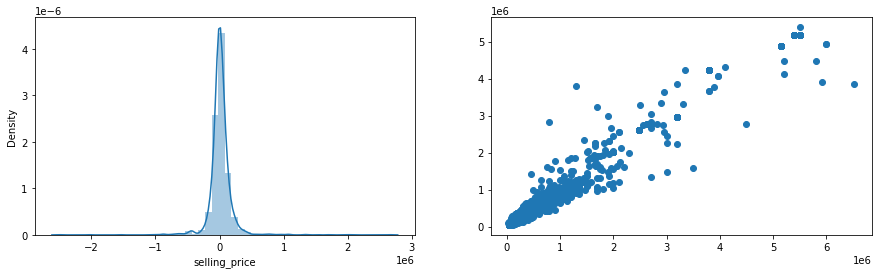

In [ ]:
fig,ax=plt.subplots(1,2)
sns.distplot((np.exp(y_test)-np.exp(y_pred)),ax=ax[0])
plt.scatter(np.exp(y_test),np.exp(y_pred))
fig.set_figwidth(15)
fig.set_figheight(4)
plt.show()

In [ ]:
per=np.percentile(data2['selling_price'].values,[5,25,50,75,85,95,99])
per

array([ 110000.,  254999.,  450000.,  675000.,  850000., 1950000.,
       5200000.])

In [ ]:
def vals(x):
  if x<per[0]:
    return 5
  elif per[0]<=x<per[1]:
    return 25
  elif per[1]<=x<per[2]:
    return 50
  elif per[2]<=x<per[3]:
    return 75
  elif per[3]<=x<per[4]:
    return 85
  elif per[4]<=x<per[5]:
    return 95
  else:
    return 99

Adding a percentile feature that classify selling price and also give weightage.

In [ ]:
data2_scaled['percentile']=data2['selling_price'].apply(lambda x:vals(x))

In [ ]:
data2_scaled.head()

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,torque,years_old,percentile
0,12.860999,1.186431,-0.953217,-0.437525,-0.385158,0.640081,-0.074804,-0.514652,-0.152674,-0.43237,-0.546375,0.198816,50
1,11.918391,0.268294,-0.953217,-0.437525,-0.385158,-2.148011,0.078209,-1.314519,-1.262564,-0.43237,-1.083659,1.682495,25
2,13.091902,0.153527,0.869782,2.421162,-0.385158,0.640081,0.121563,0.011943,-0.208871,-0.43237,0.342209,-0.295744,75
3,12.899220,0.038760,-0.953217,-0.437525,-0.385158,-0.753965,-0.074804,-0.514652,-0.152674,-0.43237,-0.546375,-0.048464,50
4,11.156251,-1.108912,0.869782,-0.437525,-0.385158,0.640081,-0.890877,0.143592,-0.961910,-0.43237,-0.732358,2.671615,5


In [ ]:
X=data2_scaled.drop('selling_price',axis=1)
y=data2_scaled['selling_price']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,shuffle=True,random_state=12)

In [ ]:
y_pred=ExtraTreesRegressor().fit(X_train,y_train).predict(X_test)
metric(y_pred,y_test)

MSE_log      = 0.018
RMSE_log     = 0.135
MAE_log      = 0.09
r2_score     = 0.9745
MSE_exp      = 8150411236.171
RMSE_exp     = 90279.628
MAE_exp      = 41515.517
r2_score_exp = 0.988


In [ ]:
scaled=StandardScaler().fit_transform(data2[['km_driven','mileage','engine','max_power','seats','torque','years_old','fuel','seller_type','transmission','owner']])
data2_scaled_mm=data2.copy()
data2_scaled_mm[['km_driven','mileage','engine','max_power','seats','torque','years_old','fuel','seller_type','transmission','owner']]=scaled

In [ ]:
data2_scaled_mm['selling_price']=np.log(data2_scaled_mm['selling_price'])
data2_scaled_mm['percentile']=data2['selling_price'].apply(lambda x:vals(x))
data2_scaled_mm['percentile']=StandardScaler().fit_transform(data2_scaled_mm['percentile'].values.reshape(-1,1))

In [ ]:
data2_scaled_mm.head()

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,torque,years_old,percentile
0,12.860999,1.186431,-0.953217,-0.437525,-0.385158,0.640081,-0.074804,-0.514652,-0.152674,-0.43237,-0.546375,0.198816,-0.359176
1,11.918391,0.268294,-0.953217,-0.437525,-0.385158,-2.148011,0.078209,-1.314519,-1.262564,-0.43237,-1.083659,1.682495,-1.279514
2,13.091902,0.153527,0.869782,2.421162,-0.385158,0.640081,0.121563,0.011943,-0.208871,-0.43237,0.342209,-0.295744,0.561161
3,12.899220,0.038760,-0.953217,-0.437525,-0.385158,-0.753965,-0.074804,-0.514652,-0.152674,-0.43237,-0.546375,-0.048464,-0.359176
4,11.156251,-1.108912,0.869782,-0.437525,-0.385158,0.640081,-0.890877,0.143592,-0.961910,-0.43237,-0.732358,2.671615,-2.015784


#### **FINAL MODEL**

In [ ]:
X=data2_scaled_mm.drop('selling_price',axis=1)
y=data2_scaled_mm['selling_price']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,shuffle=True,random_state=12)
y_pred=ExtraTreesRegressor().fit(X_train,y_train).predict(X_test)
metric(y_pred,y_test)

MSE_log      = 0.018
RMSE_log     = 0.134
MAE_log      = 0.09
r2_score     = 0.9746
MSE_exp      = 9035183902.002
RMSE_exp     = 95053.584
MAE_exp      = 41713.571
r2_score_exp = 0.987


In [ ]:
model=ExtraTreesRegressor()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
metric(y_pred,y_test)

MSE_log      = 0.018
RMSE_log     = 0.134
MAE_log      = 0.09
r2_score     = 0.9748
MSE_exp      = 8157591629.976
RMSE_exp     = 90319.387
MAE_exp      = 41285.439
r2_score_exp = 0.988


In [ ]:
X=data2_scaled_mm.drop('selling_price',axis=1)
y=data2_scaled_mm['selling_price']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,shuffle=True,random_state=12)
y_pred=ExtraTreesRegressor(n_estimators=60, n_jobs=4, min_samples_split=9,
                            min_samples_leaf=10).fit(X_train,y_train).predict(X_test)
metric(y_pred,y_test)

MSE_log      = 0.018
RMSE_log     = 0.136
MAE_log      = 0.101
r2_score     = 0.9737
MSE_exp      = 16654039096.88
RMSE_exp     = 129050.529
MAE_exp      = 55741.373
r2_score_exp = 0.974


In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb=XGBRegressor()
xgb.fit(X_train,y_train)
y_pred=xgb.predict(X_test)
metric(y_pred,y_test)

[15:52:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE_log      = 0.02
RMSE_log     = 0.142
MAE_log      = 0.111
r2_score     = 0.9713
MSE_exp      = 18168476823.344
RMSE_exp     = 134790.492
MAE_exp      = 65648.62
r2_score_exp = 0.972


In [ ]:
temp=pd.DataFrame()
temp['actual']=np.exp(y_test)
temp['predict']=np.exp(y_pred)
temp['diff']=round((np.exp(y_test)-np.exp(y_pred))*100/np.exp(y_test),2)

In [ ]:
x=temp.head(20)

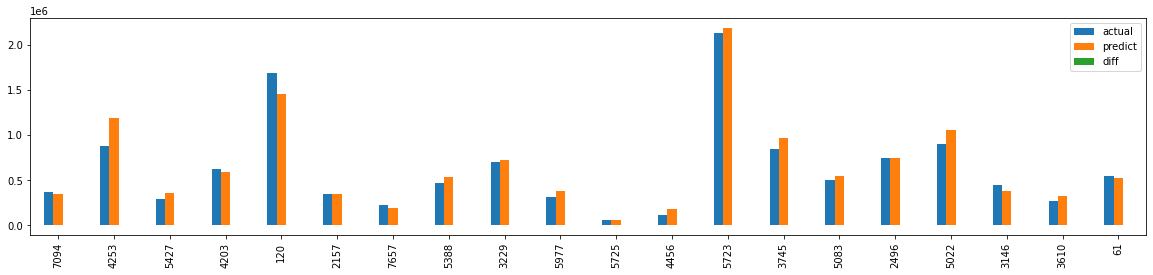

In [ ]:
x.plot(kind='bar',figsize=(20,4))

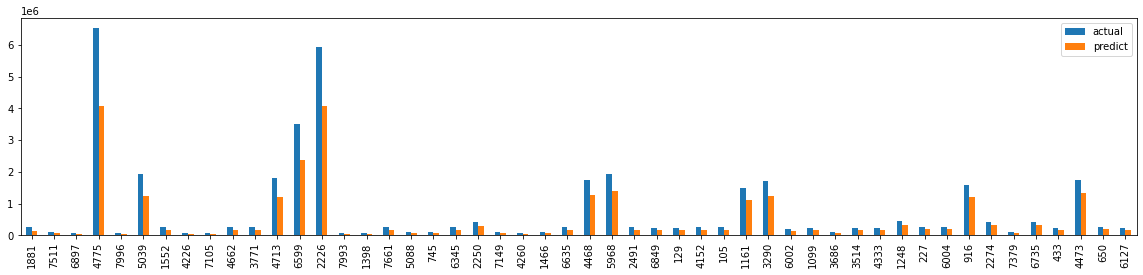

In [ ]:
x1=temp.sort_values(by='diff',ascending=False)
x2=x1[['actual','predict']].head(50)
x2.plot(kind='bar',figsize=(20,4))

In [ ]:
import pickle
file = open("file.pkl", "wb") # opening a new file in write mode
pickle.dump(model, file) # dumping created model into a pickle file

In [ ]:
pickle.load(open('file.pkl','rb'))

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [ ]:
import joblib

In [ ]:
joblib.dump(model,'car_model.pkl')

['car_model.pkl']

### **SUMMARY**:
Finally, after testing various models the ExtraTreesRegressor and XGBRegressor, with little hypertuning, performed well.The R2 score of both the models comes out to be **0.97**.

### **Future scope**:
The dataset lacks **Actual price** column, presence of which could improve the performance and reliability of the model significantly.Since, we all know that the moment car comes out of a showroom, its price starts to depreciate.Perhaps, we could use this factor in determining the current worth of a car.
